# Move distribution per piece

In [2]:
import chess
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import pandas as pd
from collections import Counter
import seaborn as sns
sns.set_theme()

Connection to database

In [3]:
conn = sqlite3.connect("chess_games.db")
cursor = conn.cursor()

Query to select all the moves for the first 20000 games

In [4]:
df = pd.read_sql_query("""
    SELECT moves.game_id, moves.move_number, piece
    FROM moves, pieces
    WHERE moves.game_id = pieces.game_id AND moves.move_number = pieces.move_number
    ORDER BY moves.game_id ASC, moves.move_number ASC
""", conn)

In [5]:
df

,game_id,move_number,piece
0,1,1,p
1,1,2,p
2,1,3,p
3,1,4,b
4,1,5,b
...,...,...,...
18851728,100000,124,p
18851729,100000,125,k
18851730,100000,126,q
18851731,100000,127,k


## Average Move Distribution per Piece Across All Games

In [6]:
# count the number of pieces and relative frequencies
piece_counts = Counter(df['piece'])
piece_counts = dict(piece_counts)
piece_counts = {k: v for k, v in sorted(piece_counts.items(), key=lambda item: item[1], reverse=True)}
# Create a DataFrame from the piece counts
piece_counts_df = pd.DataFrame.from_dict(piece_counts, orient='index', columns=['count'])
piece_counts_df['relative_frequency'] = piece_counts_df['count'] / piece_counts_df['count'].sum()
piece_counts_df 

,count,relative_frequency
k,4913874,0.260659
r,4348636,0.230676
p,3015982,0.159984
b,2698688,0.143153
n,2144215,0.113741
q,1730338,0.091787


plot the distribution per piece

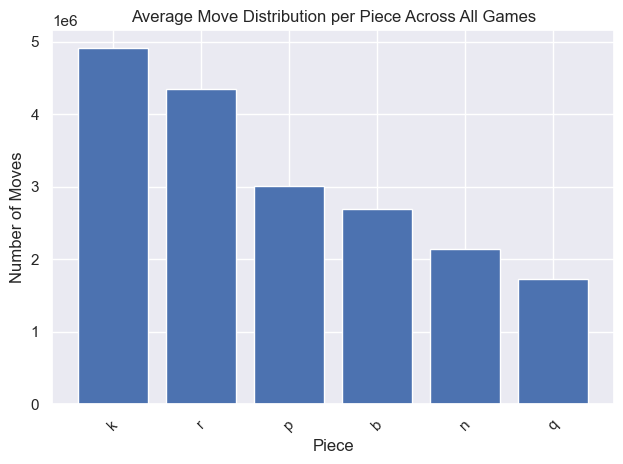

In [7]:
plt.bar(piece_counts_df.index, piece_counts_df['count'])
plt.title("Average Move Distribution per Piece Across All Games")
plt.xlabel("Piece")
plt.ylabel("Number of Moves")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Move distribution per piece dividing the phases of the game

In [8]:
def classify_phase(move_number):
    if move_number <= 10:
        return 'opening'
    elif move_number <= 30:
        return 'midgame'
    else:
        return 'endgame'
    
 #division with lenght of the game
new_df = df.copy()
new_df['phase'] = new_df['move_number'].apply(classify_phase)

In [9]:
phase_game_groups = new_df.groupby(["phase"])["piece"].apply(list)
phase_game_groups


phase
endgame    [n, b, q, b, r, r, r, r, p, b, p, q, p, p, n, ...
midgame    [n, q, q, n, p, p, p, p, n, r, p, n, b, n, k, ...
opening    [p, p, p, b, b, n, p, p, p, p, p, p, p, n, b, ...
Name: piece, dtype: object

In [10]:
# count the number of pieces in each phase
phase_piece_counts = {}

for phase, pieces in phase_game_groups.items():
    phase_piece_counts[phase] = Counter(pieces)

# Create a DataFrame from the phase piece counts
phase_piece_counts_df = pd.DataFrame.from_dict(phase_piece_counts, orient='index').fillna(0)
phase_piece_counts_df = phase_piece_counts_df.astype(int)
phase_piece_counts_df


,n,b,q,r,p,k
endgame,1407939,2128315,1482135,4069373,1895740,4868367
midgame,441211,424159,224499,251001,614226,44768
opening,295065,146214,23704,28262,506016,739


In [11]:
# distribution of pieces in each phase
phase_piece_counts_df = phase_piece_counts_df.div(phase_piece_counts_df.sum(axis=1), axis=0)
phase_piece_counts_df = phase_piece_counts_df.fillna(0)
phase_piece_counts_df

,n,b,q,r,p,k
endgame,0.088818,0.134263,0.093499,0.256713,0.119591,0.307116
midgame,0.220621,0.212094,0.112257,0.125509,0.307134,0.022386
opening,0.295065,0.146214,0.023704,0.028262,0.506016,0.000739


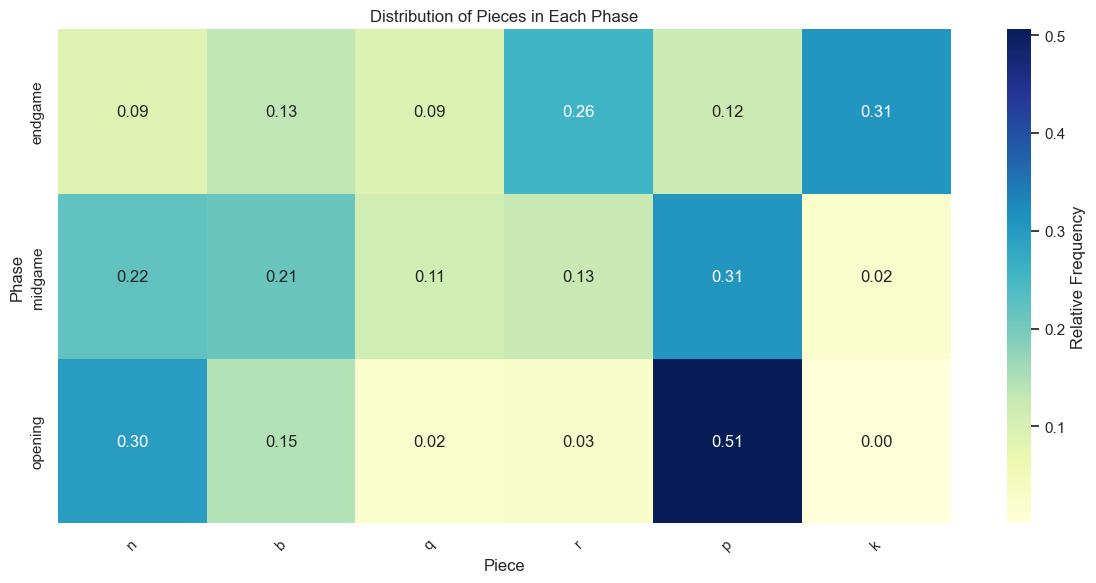

In [12]:
# plotting the distribution of pieces in each phase
plt.figure(figsize=(12, 6))
sns.heatmap(phase_piece_counts_df, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Relative Frequency'})
plt.title("Distribution of Pieces in Each Phase")
plt.xlabel("Piece")
plt.ylabel("Phase") 
plt.xticks(rotation=45)
plt.tight_layout()  
plt.show()

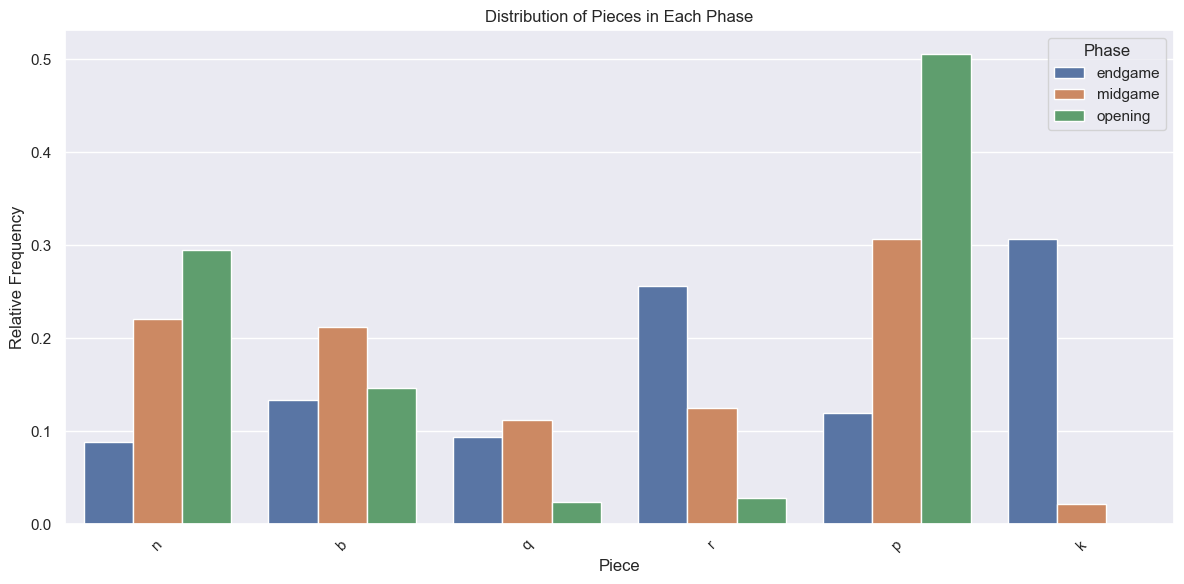

In [13]:
# barplot of the distribution of pieces in each phase
plt.figure(figsize=(12, 6))
sns.barplot(data=phase_piece_counts_df.melt(ignore_index=False, var_name='piece', value_name='value').reset_index(), x='piece', y='value', hue='index')
plt.title("Distribution of Pieces in Each Phase")
plt.xlabel("Piece")
plt.ylabel("Relative Frequency")
plt.xticks(rotation=45)
plt.legend(title='Phase')
plt.tight_layout()
plt.show()

## Heatmap of piece distribution per move

In [14]:
df

,game_id,move_number,piece
0,1,1,p
1,1,2,p
2,1,3,p
3,1,4,b
4,1,5,b
...,...,...,...
18851728,100000,124,p
18851729,100000,125,k
18851730,100000,126,q
18851731,100000,127,k


In [15]:
#group by  move_number and piece
df_grouped = df.groupby(['move_number', 'piece']).size().reset_index(name='count')

In [21]:
df_grouped
#normalize per row
df_grouped['count'] = df_grouped['count'] / df_grouped.groupby('move_number')['count'].transform('sum')

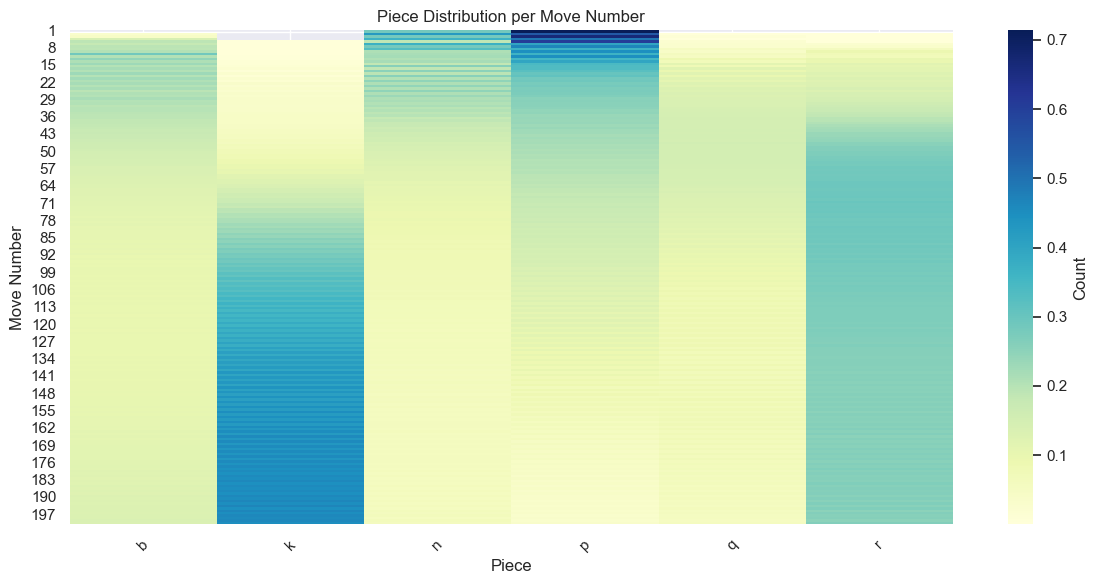

In [22]:
# heatmap of Piece distribution per move number
plt.figure(figsize=(12, 6))
sns.heatmap(df_grouped.pivot(index='move_number', columns='piece', values='count'), cmap="YlGnBu", cbar_kws={'label': 'Count'})
plt.title("Piece Distribution per Move Number")
plt.xlabel("Piece")
plt.ylabel("Move Number")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

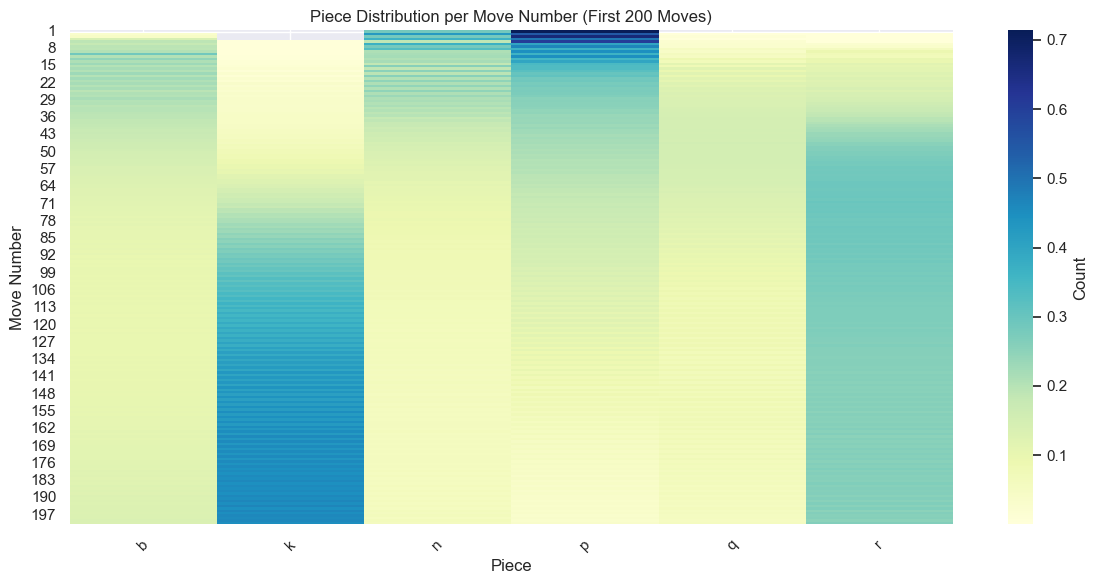

In [23]:
# remove all the moves after 200 since they are not relevant
df_grouped = df_grouped[df_grouped['move_number'] <= 200]
# heatmap of Piece distribution per move number
plt.figure(figsize=(12, 6))
sns.heatmap(df_grouped.pivot(index='move_number', columns='piece', values='count'), cmap="YlGnBu", cbar_kws={'label': 'Count'})
plt.title("Piece Distribution per Move Number (First 200 Moves)")
plt.xlabel("Piece")
plt.ylabel("Move Number")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()